In [47]:
import torch
import glob
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl

In [66]:
d={}
d["x"]=[]
d["y"]=[]
i=1
for filename in glob.glob(r"D:\PHD\Codes\AutoML\GraphNAP\results\graph_classification\DD\20-01_18h04\predictor_training_data"+'/*'):
    data=torch.load(filename)
    data.y=data.y.view(-1,1)
    d["x"].append(i)
    if data.y.cpu().item()>=0.8289:
        d["y"].append(0.8049*100)
    else:
      d["y"].append(data.y.cpu().item()*100)
    i=i+1

df = pd.DataFrame.from_dict(d,orient='columns')
df.to_excel(r"wdd_distr.xlsx")
print("max is ", max(d["y"]))

max is  81.25


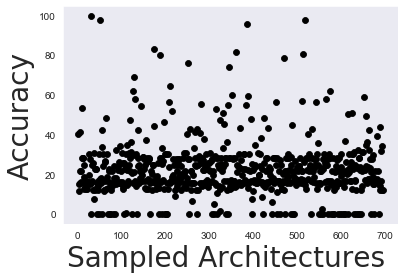

In [60]:
# plt.plot(x,  y,  color='black', linewidth=0.6)
plt.scatter(d['x'], d['y'],  color="black", linewidth=0.8)
plt.ylabel(f'Accuracy',fontsize=28,fontname="Arial Black")
plt.xlabel(f'Sampled Architectures ',fontsize=28,fontname="Arial Black")#,fontweight = 'bold'
# plt.legend()
plt.grid()

plt.savefig(r'D:\PHD\Codes\AutoML\GraphNAP\wfig_distr.pdf',bbox_inches="tight",dpi=1000)
plt.show()

In [32]:
class ShuffleDataset(torch.utils.data.IterableDataset):

  def __init__(self, dataset, buffer_size):
    super().__init__()
    self.dataset = dataset
    self.buffer_size = buffer_size

  def __iter__(self):
    shufbuf = []
    try:
      dataset_iter = iter(self.dataset)
      for i in range(self.buffer_size):
        shufbuf.append(next(dataset_iter))
    except:
      self.buffer_size = len(shufbuf)

    try:
      while True:
        try:
          item = next(dataset_iter)
          evict_idx = random.randint(0, self.buffer_size - 1)
          yield shufbuf[evict_idx]
          shufbuf[evict_idx] = item
        except StopIteration:
          break
      while len(shufbuf) > 0:
        yield shufbuf.pop()
    except GeneratorExit:
      pass

dataset = ShuffleDataset(dataset, 1024)

In [ ]:
print(dir(dataset))

In [22]:
for d in dataset:
    print(d.y)

NameError: name 'dataset' is not defined

In [ ]:
print(dataset.dataset)

In [ ]:
for d in dataset:
    print(d.y)

In [ ]:
htw

In [ ]:
How To Run.



1 Setup New environment  (using anaconda)
 # create environment by running the following command
     conda create -n ocr python=3.8 anaconda
 # install required packages by running
  a- conda install pytorch torchvision torchaudio pytorch-cuda=11.6 -c pytorch -c nvidia
  b- conda install pyg -c pyg
  c- !pip install paddlepaddle
  d-  !pip install -r D:\Obm\Code_for_table_extraction\requirements.txt    (The path to "requirement.txt" need to be updated before running this command)


2. Select Conda environment "ocr" for running by running the following command
  conda activate ocr
3- Navigate to project code root directory
   cd  D:\Obm\Code_for_table_extraction  (The path to root need to be updated)
 4- run script
    # run using command line
     python  PaddleOCR/ppstructure/table/predict_table.py  --image_dir=path_to_imge_files --output=path_to_output_dir
   # or run from pycharm
        a- update image_dir and output_dir variable in line 100 and 101, respectively
        b- Run main.py



In [ ]:
pt

In [ ]:
# Copyright (c) 2020 PaddlePaddle Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import random
import sys
__dir__ = os.path.dirname(os.path.abspath(__file__))
sys.path.append(__dir__)
sys.path.insert(0, os.path.abspath(os.path.join(__dir__, '..')))
sys.path.insert(0, os.path.abspath(os.path.join(__dir__, '../..')))

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


os.environ["FLAGS_allocator_strategy"] = 'auto_growth'
import pandas as pd
import dataframe_image as dfi
from translators import dispatch as run_translation
import shutil
import asyncio
import cv2
import copy
import logging
import numpy as np
import time
import tools.infer.predict_rec as predict_rec
import tools.infer.predict_det as predict_det
import tools.infer.utility as utility
from tools.infer.predict_system import sorted_boxes
from ppocr.utils.utility import get_image_file_list, check_and_read
from ppocr.utils.logging import get_logger
from ppstructure.table.matcher import TableMatch
from ppstructure.table.table_master_match import TableMasterMatcher
from ppstructure.utility import parse_args
import ppstructure.table.predict_structure as predict_strture
from multiprocessing import Process
import string
logger = get_logger()


def _check_file_extension(path):
    img_end = {'xls',"xlsx"}
    return any([path.lower().endswith(e) for e in img_end])

def expand(pix, det_box, shape):
    x0, y0, x1, y1 = det_box
    #     print(shape)
    h, w, c = shape
    tmp_x0 = x0 - pix
    tmp_x1 = x1 + pix
    tmp_y0 = y0 - pix
    tmp_y1 = y1 + pix
    x0_ = tmp_x0 if tmp_x0 >= 0 else 0
    x1_ = tmp_x1 if tmp_x1 <= w else w
    y0_ = tmp_y0 if tmp_y0 >= 0 else 0
    y1_ = tmp_y1 if tmp_y1 <= h else h
    return x0_, y0_, x1_, y1_

def get_file_list(files_path):
    imgs_lists = []
    if files_path is None or not os.path.exists(files_path):
        raise Exception("not found any img file in {}".format(files_path))

    if os.path.isfile(files_path) and _check_file_extension(files_path):
        imgs_lists.append(files_path)
    elif os.path.isdir(files_path):
        for single_file in os.listdir(files_path):
            file_path = os.path.join(files_path, single_file)
            if os.path.isfile(file_path) and _check_file_extension(file_path):
                imgs_lists.append(file_path)
    if len(imgs_lists) == 0:
        raise Exception("not found any img file in {}".format(files_path))
    imgs_lists = sorted(imgs_lists)
    return imgs_lists


def translate_and_transform(file_path,output_dir):
    file_list=get_file_list(file_path)
    for i, file_name in enumerate(file_list):
        img_name= f'{os.path.splitext(file_name)[0]}.png'
        file=pd.read_excel(file_name)
        for col in file.columns:
            if "unnamed" in str(col).lower():
                file = file.rename(columns={col: ""})
            else:
                file = file.rename(columns={col: translate_to_english(col)})

        for i in range(file.shape[0]):
            for j in range(file.shape[1]):
                cell_val = file.iat[i,j]
                if str(cell_val).lower()=="nan":
                    cell_val=""
                else:
                    cell_val = translate_to_english(cell_val)
                file.iat[i, j] =cell_val
        file.to_excel(file_name)
        dfi.export(file.style.hide(axis="index"),img_name)


def translate_to_english(seq):
    tr = asyncio.run(run_translation("deepl", 'auto', "ENG", [str(text) for text in [seq]], "default", "Store_true"))
    print(f"type of res {type(tr)}")
    if len(tr) > 0:
        return tr[0]
    else:
        return ""
class TableSystem(object):
    def __init__(self, args, text_detector=None, text_recognizer=None):
        self.args = args
        if not args.show_log:
            logger.setLevel(logging.INFO)
        benchmark_tmp = False
        if args.benchmark:
            benchmark_tmp = args.benchmark
            args.benchmark = False
        self.text_detector = predict_det.TextDetector(copy.deepcopy(
            args)) if text_detector is None else text_detector
        self.text_recognizer = predict_rec.TextRecognizer(copy.deepcopy(
            args)) if text_recognizer is None else text_recognizer
        if benchmark_tmp:
            args.benchmark = True
        self.table_structurer = predict_strture.TableStructurer(args)
        if args.table_algorithm in ['TableMaster']:
            self.match = TableMasterMatcher()
        else:
            self.match = TableMatch(filter_ocr_result=True)

        self.predictor, self.input_tensor, self.output_tensors, self.config = utility.create_predictor(
            args, 'table', logger)

    def __call__(self, img, return_ocr_result_in_table=False):
        result = dict()
        time_dict = {'det': 0, 'rec': 0, 'table': 0, 'all': 0, 'match': 0}
        start = time.time()
        structure_res, elapse = self._structure(copy.deepcopy(img))
        result['cell_bbox'] = structure_res[1].tolist()
        time_dict['table'] = elapse

        dt_boxes, rec_res, det_elapse, rec_elapse = self._ocr(
            copy.deepcopy(img))
        time_dict['det'] = det_elapse
        time_dict['rec'] = rec_elapse

        if return_ocr_result_in_table:
            result['boxes'] = dt_boxes  #[x.tolist() for x in dt_boxes]
            result['rec_res'] = rec_res

        tic = time.time()
        pred_html = self.match(structure_res, dt_boxes, rec_res)
        toc = time.time()
        time_dict['match'] = toc - tic
        result['html'] = pred_html
        end = time.time()
        time_dict['all'] = end - start
        return result, time_dict

    def _structure(self, img):
        structure_res, elapse = self.table_structurer(copy.deepcopy(img))
        return structure_res, elapse

    def _ocr(self, img):
        h, w = img.shape[:2]
        dt_boxes, det_elapse = self.text_detector(copy.deepcopy(img))
        dt_boxes = sorted_boxes(dt_boxes)

        r_boxes = []
        for box in dt_boxes:
            x_min = max(0, box[:, 0].min() - 1)
            x_max = min(w, box[:, 0].max() + 1)
            y_min = max(0, box[:, 1].min() - 1)
            y_max = min(h, box[:, 1].max() + 1)
            box = [x_min, y_min, x_max, y_max]
            r_boxes.append(box)
        dt_boxes = np.array(r_boxes)
        logger.debug("dt_boxes num : {}, elapse : {}".format(
            len(dt_boxes), det_elapse))
        if dt_boxes is None:
            return None, None

        img_crop_list = []
        for i in range(len(dt_boxes)):
            det_box = dt_boxes[i]
            x0, y0, x1, y1 = expand(2, det_box, img.shape)
            text_rect = img[int(y0):int(y1), int(x0):int(x1), :]
            img_crop_list.append(text_rect)
        rec_res, rec_elapse = self.text_recognizer(img_crop_list)
        logger.debug("rec_res num  : {}, elapse : {}".format(
            len(rec_res), rec_elapse))
        return dt_boxes, rec_res, det_elapse, rec_elapse


def to_excel(html_table, excel_path):
    from tablepyxl import tablepyxl
    tablepyxl.document_to_xl(html_table, excel_path)

def get_random_name(n=20):
    characters = string.ascii_letters + string.digits
    password = ''.join(random.choice(characters) for i in range(n))
    return password

def get_output(args,i,img_num, image_file):
    logger.info("[{}/{}] {}".format(i, img_num, image_file))
    img, flag, _ = check_and_read(image_file)
    # tmp = f"{get_random_name(8)}{i}.jpg"
    # shutil.copy(image_file, tmp)

    excel_path = os.path.join(
        args.output, os.path.basename(image_file).split('.')[0] + '.xlsx')
    table_sys = TableSystem(args)
    # try:
    if not flag:
        # img = cv2.imread(image_file)
        img=cv2.imdecode(np.fromfile(image_file, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

        # os.remove(tmp)
    if img is None:
        logger.error("error in loading image:{}".format(image_file))
    starttime = time.time()
    pred_res, _ = table_sys(img)
    pred_html = pred_res['html']
    # logger.info(pred_html)
    to_excel(pred_html, excel_path)  # Save predicted table in Excel file
    logger.info('excel saved to {}'.format(excel_path))

    translate_and_transform(excel_path, args.output)
    # except:
    #     print("An error occur, Table not extracted!")
def main(args):


    image_file_list = get_image_file_list(args.image_dir)
    image_file_list = image_file_list[args.process_id::args.total_process_num]
    os.makedirs(args.output, exist_ok=True)


    img_num = len(image_file_list)

    for i, image_file in enumerate(image_file_list):
        out=Process(target=get_output, args=(args,i, img_num, image_file))
        out.start()
    out.terminate()





# if __name__ == "__main__":
def run(output_dir, image_dir):
    args = parse_args(output_dir, image_dir)
    if args.use_mp:
        import subprocess
        p_list = []
        total_process_num = args.total_process_num
        for process_id in range(total_process_num):
            cmd = [sys.executable, "-u"] + sys.argv + [
                "--process_id={}".format(process_id),
                "--use_mp={}".format(False)
            ]
            p = subprocess.Popen(cmd, stdout=sys.stdout, stderr=sys.stdout)
            p_list.append(p)
        for p in p_list:
            p.wait()
    else:
        main(args)
    return args.output


if __name__ == "__main__":

    args = parse_args("a","b")
    if args.use_mp:
        import subprocess
        p_list = []
        total_process_num = args.total_process_num
        for process_id in range(total_process_num):
            cmd = [sys.executable, "-u"] + sys.argv + [
                "--process_id={}".format(process_id),
                "--use_mp={}".format(False)
            ]
            p = subprocess.Popen(cmd, stdout=sys.stdout, stderr=sys.stdout)
            p_list.append(p)
        for p in p_list:
            p.wait()
    else:
        main(args)


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Load the example diamonds dataset
diamonds = sns.load_dataset("diamonds")

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
sns.scatterplot(x="carat", y="price",
                hue="clarity", size="depth",
                palette="ch:r=-.2,d=.3_r",
                hue_order=clarity_ranking,
                sizes=(1, 8), linewidth=0,
                data=diamonds, ax=ax)

URLError: <urlopen error [Errno 11004] getaddrinfo failed>

URLError: <urlopen error [Errno 11004] getaddrinfo failed>

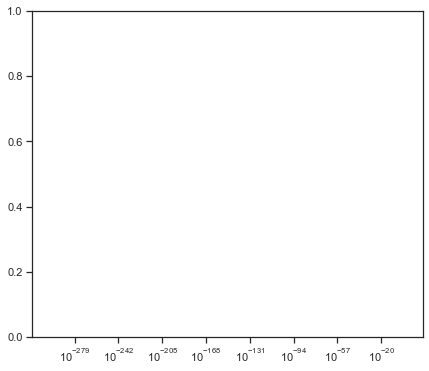

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Load the example planets dataset
planets = sns.load_dataset("planets")

# Plot the orbital period with horizontal boxes
sns.boxplot(x="distance", y="method", data=planets,
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="distance", y="method", data=planets,
              size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [6]:
import seaborn as sns
sns.set_theme(style="ticks")

dots = sns.load_dataset("dots")

# Define the palette as a list to specify exact values
palette = sns.color_palette("rocket_r")

# Plot the lines on two facets
sns.relplot(
    data=dots,
    x="time", y="firing_rate",
    hue="coherence", size="choice", col="align",
    kind="line", size_order=["T1", "T2"], palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

URLError: <urlopen error [Errno 11004] getaddrinfo failed>

In [7]:
import seaborn as sns
sns.set_theme(style="ticks")

# Load the penguins dataset
penguins = sns.load_dataset("penguins")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=penguins,
    x="bill_length_mm", y="bill_depth_mm", hue="species",
    kind="kde",
)

URLError: <urlopen error [Errno 11004] getaddrinfo failed>

In [ ]:
import seaborn as sns
sns.set_theme(style="white", color_codes=True)
mpg = sns.load_dataset("mpg")

# Use JointGrid directly to draw a custom plot
g = sns.JointGrid(data=mpg, x="mpg", y="acceleration", space=0, ratio=17)
g.plot_joint(sns.scatterplot, size=mpg["horsepower"], sizes=(30, 120),
             color="g", alpha=.6, legend=False)
g.plot_marginals(sns.rugplot, height=1, color="g", alpha=.6)

In [11]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Load the diamonds dataset
diamonds = sns.load_dataset("diamonds")

# Plot the distribution of clarity ratings, conditional on carat
sns.displot(
    data=diamonds,
    x="carat", hue="cut",
    kind="kde", height=6,
    multiple="fill", clip=(0, None),
    palette="ch:rot=-.25,hue=1,light=.75",
)

TimeoutError: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

tips = sns.load_dataset("tips")
g = sns.jointplot(x="total_bill", y="tip", data=tips,
                  kind="reg", truncate=False,
                  xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Load the example planets dataset
planets = sns.load_dataset("planets")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=planets,
    x="distance", y="orbital_period",
    hue="year", size="mass",
    palette=cmap, sizes=(10, 200),
)
g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)

C:\Users\molou\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\molou\miniconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\molou\miniconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\molou\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) i

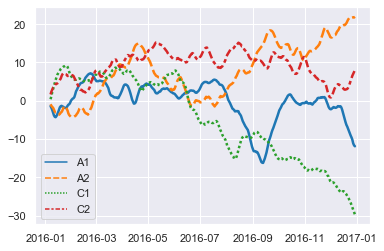

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

rs = np.random.RandomState(300)
values = rs.randn(365, 4).cumsum(axis=0)
dates = pd.date_range("1 1 2016", periods=365, freq="D")
data = pd.DataFrame(values, dates, columns=["A1", "A2", "C1", "C2"])
data = data.rolling(7).mean()

sns.lineplot(data=data, palette="tab10", linewidth=2.5)

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

# Load the example mpg dataset
mpg = sns.load_dataset("mpg")

# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="horsepower", y="mpg", hue="origin", size="weight",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=mpg)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="abbrev", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Load the example planets dataset
planets = sns.load_dataset("planets")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=planets,
    x="distance", y="orbital_period",
    hue="year", size="mass",
    palette=cmap, sizes=(10, 200),
)
g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)